## Centrality, Genre, Popularity

In [1]:
### Some parts of the code depend on Siqi Wu's code: https://github.com/avalanchesiqi/networked-popularity
### In order to run the code, please clone Siqi Wu's repo and put this file in the root directory.
### Remember to download all data from https://drive.google.com/drive/folders/19R3_2hRMVqlMGELZm47ruk8D9kqJvAmL?usp=sharing
### And put all data to the data folder.

### Author: Yutian Zhao
### Reference from: Siqi Wu

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [86]:
import sys, os, platform, pickle, json, time
from datetime import datetime, timedelta
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import math
import scipy as sp
import scipy.stats
from scipy.stats import pearsonr, percentileofscore
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from utils.data_loader import DataLoader
from utils.plot import ColorPalette, concise_fmt, hide_spines, stackedBarPlot
from utils.helper import is_same_genre, gini
data_prefix = 'data/' # ../

from powerlaw import Fit, plot_ccdf, plot_pdf

import matplotlib as mpl
if platform.system() == 'Linux':
    mpl.use('Agg')  # no UI backend

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.rcParams['lines.linewidth'] = 1

In [2]:
T = 63

In [3]:
def mean_scatter(x, y, c1='grey', c2='blue'):
    plt.scatter(x, y, s=2, color=c1, marker='o', alpha=0.5)
    data = np.zeros((len(x), 2))
    data[:, 0] = x
    data[:, 1] = y
    data = data[data[:, 0].argsort()]
    data_split = np.split(data[:,1], np.unique(data[:, 0], return_index=True)[1][1:])
    y_mean = [np.mean(i) for i in data_split]
    plt.scatter(np.sort(np.unique(data[:, 0])), y_mean, s=2, color=c2, marker='o', alpha=0.5)

In [4]:
data_loader = DataLoader()
data_loader.load_embed_content_dict()
# data_loader.cwd
embed_view_dict = data_loader.embed_view_dict
embed_avg_view_dict = data_loader.embed_avg_view_dict
num_videos = data_loader.num_videos
embed_title_dict = data_loader.embed_title_dict
embed_genre_dict = data_loader.embed_genre_dict
embed_all_genre_dict = data_loader.embed_all_genre_dict

>>> Daily view data has been loaded!


In [5]:
embed_cid_dict = data_loader.embed_cid_dict

In [6]:
### contrust network graph for each day
if not os.path.exists(os.path.join(data_prefix, "video_network.pkl")):
    graph_lst = []
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)
        
    with open(os.path.join(data_prefix, "video_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "video_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)

In [7]:
indegree_lists = []
for i in range(T):
    indegree_list = []
    for j in range(num_videos):
        if graph_lst[i].has_node(j):
            indegree_list.append(graph_lst[i].in_degree(j))
        else:
            indegree_list.append(0)
    indegree_lists.append(indegree_list)
indegree_lists = np.array(indegree_lists)

In [8]:
min_ind = np.min(indegree_lists)
print(min_ind)
max_ind = np.max(indegree_lists)
print(max_ind)
mean_ind = np.mean(indegree_lists)
print(mean_ind)
std_ind = np.std(indegree_lists)
print(std_ind)

0
1271
5.97571668992479
21.841518504001634


In [9]:
avg_ind_list = np.mean(indegree_lists, axis=0) # in order
print(avg_ind_list.shape)
min_ind = np.min(avg_ind_list)
print(min_ind)
max_ind = np.max(avg_ind_list)
print(max_ind)
mean_ind = np.mean(avg_ind_list)
print(mean_ind)
std_ind = np.std(avg_ind_list)
print(std_ind)

(60740,)
0.0
870.6190476190476
5.97571668992479
20.828589212764456


In [10]:
# 5 min
if not os.path.exists(os.path.join(data_prefix, "cc_lists_15.pkl")):
    cc_lists = []
    for i in range(T):
        cc_list = []
        for j in range(num_videos):
            if graph_lst[i].has_node(j):
                cc_list.append(nx.clustering(graph_lst[i], j))
            else:
                cc_list.append(0)
        cc_lists.append(cc_list)
    cc_lists = np.array(cc_lists)
    with open(os.path.join(data_prefix, "cc_lists_15.pkl"), 'wb') as fout:
            pickle.dump(cc_lists, fout)
else:
    with open(os.path.join(data_prefix, "cc_lists_15.pkl"), 'rb') as fin:
        cc_lists = pickle.load(fin)
        
print(cc_lists.shape)

(63, 60740)


In [11]:
avg_cc_list = np.mean(cc_lists, axis=0) # in order
print(avg_cc_list.shape)
min_cc = np.min(avg_cc_list)
print(min_cc)
max_cc = np.max(avg_cc_list)
print(max_cc)
mean_cc = np.mean(avg_cc_list)
print(mean_cc)
std_cc = np.std(avg_cc_list)
print(std_cc)

(60740,)
0.0
0.9587301587301587
0.14656105445036346
0.10597113300461115


In [12]:
avg_num_edges = np.mean([G.number_of_edges() for G in graph_lst])
print(avg_num_edges)

362965.0317460318


In [13]:
avg_view_list = []
for i in range(num_videos):
    avg_view_list.append(embed_avg_view_dict[i])
avg_view_list = np.array(avg_view_list)
print(avg_view_list.shape)

(60740,)


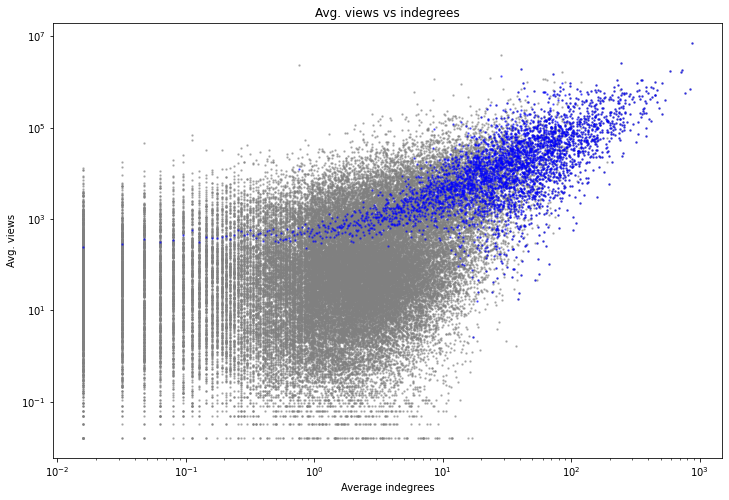

In [349]:
plt.figure(figsize=(12,8))
mean_scatter(avg_ind_list, avg_view_list)
plt.title("Figure 5. Avg.views vs avg. indegrees")
plt.xlabel("Avg. indegrees")
plt.ylabel("Avg. views")
plt.xscale("log")
plt.yscale("log")
plt.savefig("3.jpg")

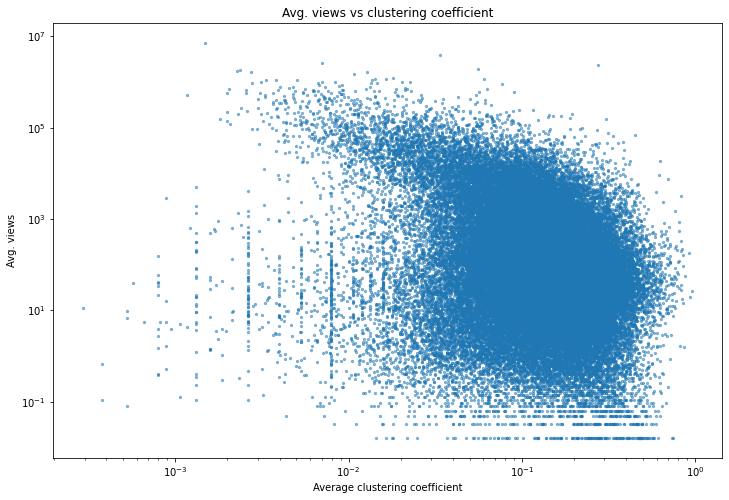

In [348]:
plt.figure(figsize=(12,8))
plt.scatter(avg_cc_list, avg_view_list, s=5, alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.title("Figure 6. Avg. views vs avg. clustering coefficient")
plt.xlabel("Avg. clustering coefficient")
plt.ylabel("Avg. views")
plt.savefig("4.jpg")

In [311]:
for i in np.sort(np.unique(avg_ind_list))[:10]:
    max_view = np.max(avg_view_list[avg_ind_list==i])
    vid = np.nonzero(avg_view_list==max_view)[0][0]
    print(vid, avg_ind_list[vid], embed_title_dict[vid])
# 2 live video pointing to and by non-vevo
# 10 pointing to other by the same singer but not pointed by.
# single.
# 3 not many videos on vevo or other non-official videos are popular thus not in the top 15

38611 0.0 The Chainsmokers, NGHTMRE - Save Yourself (Lyric Video)
50550 0.015873015873015872 Shania Twain - You're Still The One (Live)
10344 0.031746031746031744 Jennifer Lopez, Ozuna - El Anillo (Remix - Audio)
47651 0.047619047619047616 Post Malone - rockstar ft. 21 Savage
13581 0.06349206349206349 Christina Aguilera - Accelerate (Official Video) ft. Ty Dolla $ign, 2 Chainz
59144 0.07936507936507936 Florida Georgia Line - Smooth
29361 0.09523809523809523 Imagine Dragons - Next To Me (Official Music Video)
42012 0.1111111111111111 P!nk - Secrets (Official Video)
30282 0.12698412698412698 Travis Scott - ASTROWORLD TRAILER (STARGAZING)
51715 0.14285714285714285 Imagine Dragons - Shots (Official Music Video)


In [334]:
mask = np.logical_and(avg_view_list>0, avg_cc_list>=0.7)
sort_views_ind = np.argsort(avg_view_list[mask])
sort_ids = np.array([*range(num_videos)])[mask][sort_views_ind]
for vid in sort_ids[:5]:
#     vid = np.nonzero(avg_view_list==i)[0][0]
    print(vid, indegree_lists[:, vid], avg_view_list[vid], embed_title_dict[vid])
for vid in sort_ids[-5:]:
#     vid = np.nonzero(avg_view_list==i)[0][0]
    print(vid, indegree_lists[:, vid],avg_cc_list[vid], avg_view_list[vid], embed_title_dict[vid])
# special types
# hot hits
# different artist same style 

56817 [4 7 6 7 7 6 7 7 9 9 8 6 7 6 8 7 7 7 8 8 9 8 9 6 7 7 7 7 6 8 7 7 8 7 7 7 6
 7 7 6 7 7 8 6 5 7 6 9 7 7 9 8 6 7 9 7 6 7 9 8 8 8 7] 0.015873015873015872 Joe Wheeler - Lets Get Mashed Up (Instrumental Version) (AUDIO)
40343 [6 7 6 6 7 6 7 5 6 7 7 6 7 7 8 6 7 5 6 8 8 8 8 9 6 8 9 7 6 7 7 7 7 8 8 7 5
 5 8 8 7 5 8 6 5 7 6 8 8 9 7 8 7 8 8 7 8 7 9 7 7 7 7] 0.015873015873015872 Joe Wheeler - Out of House (Audio)
38640 [2 3 3 2 2 2 2 2 3 3 3 2 3 3 2 2 3 3 3 2 3 3 2 2 2 2 3 2 1 2 2 2 3 2 2 3 2
 3 2 2 2 2 2 3 2 2 2 2 2 3 1 2 3 2 2 2 2 2 2 2 3 3 1] 0.20634920634920634 Yuck - Toazted Interview 2013 (part 2)
46851 [2 2 2 2 2 2 1 1 2 2 1 1 2 2 2 2 1 0 1 2 2 2 1 2 1 2 2 1 2 1 2 2 1 1 2 1 2
 1 1 2 1 1 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 1 1 2 2 2 2] 0.873015873015873 Monster Magnet - Toazted Interview 1995 (part 1 of 3)
44934 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] 1.5873015873015872 deadmau5 - Meowingtons Hax 2k11 TO

In [14]:
with open(os.path.join(data_prefix, "s_avg_view_list_0.pkl"), 'rb') as fin:
        avg_view_list_0 = pickle.load(fin)

In [15]:
lscc_0 = max(nx.strongly_connected_components(graph_lst[0]), key=len)
lscc_avg_view_0 = [embed_avg_view_dict[v] for v in lscc_0]
    

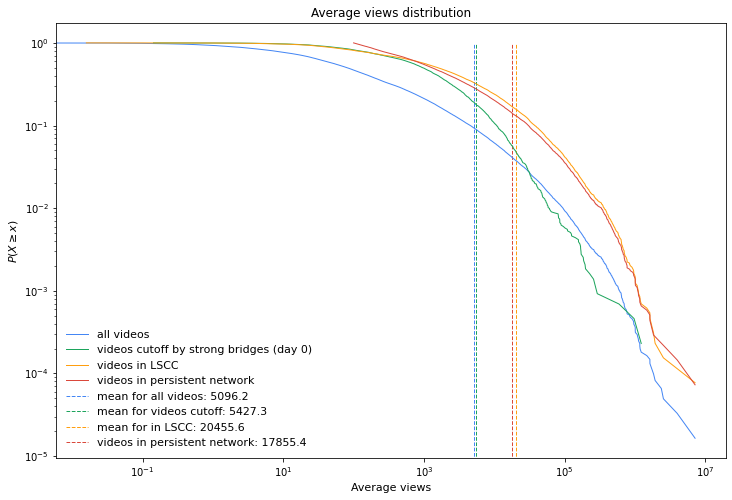

In [352]:
# usable
fig, ax1 = plt.subplots(figsize=(12,8))
plot_ccdf(avg_view_list, ax=ax1, label='all videos' ,color=ColorPalette.CC4[0])
plot_ccdf(avg_view_list_0, ax=ax1, label='videos cutoff by strong bridges (day 0)',color=ColorPalette.CC4[1])
plot_ccdf(lscc_avg_view_0, ax=ax1, label='videos in LSCC', color=ColorPalette.CC4[2])
plot_ccdf(persistent_avg_view_list, ax=ax1, label='videos in persistent network', color=ColorPalette.CC4[3])

ax1.vlines(np.mean(avg_view_list), 0, 1, linestyle='dashed', color=ColorPalette.CC4[0], label='mean for all videos: {:.1f}'.format(np.mean(avg_view_list)))
ax1.vlines(np.mean(avg_view_list_0), 0, 1, linestyle='dashed',color=ColorPalette.CC4[1], label='mean for videos cutoff: {:.1f}'.format(np.mean(avg_view_list_0)))
ax1.vlines(np.mean(lscc_avg_view_0), 0, 1, linestyle='dashed', color=ColorPalette.CC4[2], label='mean for in LSCC: {:.1f}'.format(np.mean(lscc_avg_view_0)))
ax1.vlines(np.mean(persistent_avg_view_list), 0, 1, linestyle='dashed', color=ColorPalette.CC4[3], label='videos in persistent network: {:.1f}'.format(np.mean(persistent_avg_view_list)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Average views', fontsize=11)
ax1.set_ylabel('$P(X \geq x)$', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Figure 1. Avg. views distribution', fontsize=12)
ax1.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)

plt.savefig("1.jpg")

In [17]:
print(pearsonr(avg_view_list, avg_ind_list))
print(pearsonr(avg_view_list, avg_cc_list))
print(pearsonr(avg_ind_list, avg_cc_list))

(0.535981654161106, 0.0)
(-0.09486011659291047, 2.06011975451955e-121)
(-0.17915160526862905, 0.0)


In [18]:
da_dg_lists = []
da_sg_lists = []
sa_dg_lists = []
sa_sg_lists = []
for i in tqdm(range(T)):
    da_dg_list = []
    da_sg_list = []
    sa_dg_list = []
    sa_sg_list = []
    for j in range(num_videos):
        da_dg = 0
        da_sg = 0
        sa_dg = 0
        sa_sg = 0        
        if graph_lst[i].has_node(j):
            avg_ind = avg_ind_list[j]
            if avg_ind == 0:
                da_dg_list.append(0)
                da_sg_list.append(0)
                sa_dg_list.append(0)
                sa_sg_list.append(0)
            else:            
                for src in graph_lst[i].predecessors(j):
                    if (embed_cid_dict[src] == embed_cid_dict[j]) and is_same_genre(embed_all_genre_dict[src], embed_all_genre_dict[j]):
                        sa_sg += 1
                    elif (embed_cid_dict[src] != embed_cid_dict[j]) and is_same_genre(embed_all_genre_dict[src], embed_all_genre_dict[j]):
                        da_sg += 1
                    elif (embed_cid_dict[src] == embed_cid_dict[j]) and not is_same_genre(embed_all_genre_dict[src], embed_all_genre_dict[j]):
                        sa_dg += 1
                    else:
                        da_dg += 1
    
                da_dg_list.append(da_dg/avg_ind)
                da_sg_list.append(da_sg/avg_ind)
                sa_dg_list.append(sa_dg/avg_ind)
                sa_sg_list.append(sa_sg/avg_ind)
        else:
            da_dg_list.append(0)
            da_sg_list.append(0)
            sa_dg_list.append(0)
            sa_sg_list.append(0)
    da_dg_lists.append(da_dg_list)
    da_sg_lists.append(da_sg_list)
    sa_dg_lists.append(sa_dg_list)
    sa_sg_lists.append(sa_sg_list)    
da_dg_lists = np.array(da_dg_lists)
da_sg_lists = np.array(da_sg_lists)
sa_dg_lists = np.array(sa_dg_lists)
sa_sg_lists = np.array(sa_sg_lists)
avg_da_dg = np.mean(da_dg_lists)
avg_da_sg = np.mean(da_sg_lists)
avg_sa_dg = np.mean(sa_dg_lists)
avg_sa_sg = np.mean(sa_sg_lists)
total_avg = avg_da_dg+ avg_da_sg+ avg_sa_dg+ avg_sa_sg
print(avg_da_dg/total_avg, avg_da_sg/total_avg, avg_sa_dg/total_avg, avg_sa_sg/total_avg)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:35<00:00,  1.75it/s]


0.05071508333839347 0.13564058974297605 0.14746612384036206 0.6661782030782684


0.11331742076789472


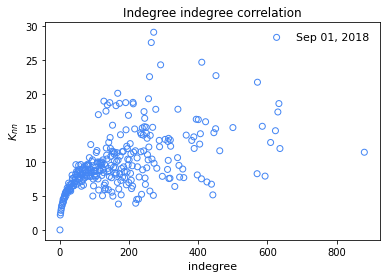

In [353]:
fig, ax1 = plt.subplots()
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0]: # , 15, 30, 45
    # calculate average nearest neighbor degree of nodes with degree k
    ind_dict = nx.k_nearest_neighbors(graph_lst[i], source='in', target='in')
    items = sorted(ind_dict.items(), key=lambda x:x[0])
    
    ax1.scatter([i for i, _ in items], [j for _, j in items], color=ColorPalette.CC4[int(i/15)], marker='o', facecolors='none', label=date_labels[int(i/15)])
    
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlabel('indegree', fontsize=11)
ax1.set_ylabel('$K_{nn}$', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Figure 3. Indegree indegree correlation', fontsize=12)
ax1.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)

# plt.show()
print(nx.degree_pearson_correlation_coefficient(graph_lst[0], x='in', y='in'))
plt.savefig("2.jpg")

In [20]:
nn_ind = defaultdict(list)
for i in graph_lst[0].nodes():
    for j in graph_lst[0].predecessors(i):
        nn_ind[graph_lst[0].in_degree(i)].append(graph_lst[0].in_degree(j)) 
avg_nn_ind = {}
for k, v in nn_ind.items():
    avg_nn_ind[k] = np.mean(v)
print(avg_nn_ind[1], avg_nn_ind[200])

2.199152175793754 10.325


In [21]:
ind_dict = nx.k_nearest_neighbors(graph_lst[0], source='in', target='in')
ind_dict[200]

10.325

In [22]:
avg_neighbour_ind_lst = np.zeros(num_videos)
for i in range(T):
    for v in graph_lst[i].nodes():
        neighbour_inds = []
        for j in graph_lst[i].predecessors(v):
            neighbour_inds.append(graph_lst[i].in_degree(j))
        if len(neighbour_inds) == 0:
            avg_neighbour_ind = 0
        else:
            avg_neighbour_ind = np.mean(neighbour_inds)
        avg_neighbour_ind_lst[v] += avg_neighbour_ind
#     avg_neighbour_ind_dict = nx.average_neighbor_degree(graph_lst[i], source='in', target='in')
#     for k, v in avg_neighbour_ind_dict.items():
#         avg_neighbour_ind_lst[k] += v

avg_neighbour_ind_lst = avg_neighbour_ind_lst/T

In [23]:
# avg_neighbour_ind_lst = np.zeros(num_videos)
# for i in graph_lst[0].nodes():
#     l = []
#     for j in graph_lst[0].predecessors(i):
#         l.append(graph_lst[0].in_degree(j))
#     if len(l) == 0:
#         lm = 0
#     else:
#         lm = np.mean(l)
#     avg_neighbour_ind_lst[i] = lm



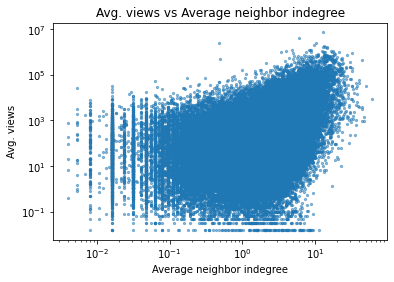

In [354]:
plt.scatter(avg_neighbour_ind_lst, avg_view_list, s=5, marker='o', alpha=0.5)
plt.title("Figure 7a. Avg. views vs Avg. neighbor indegree")
plt.xlabel("Average neighbor indegree")
plt.ylabel("Avg. views")
plt.xscale('log')
plt.yscale('log')
# plt.show();
plt.savefig("6.jpg")

In [25]:
# plt.figure(figsize=(16, 8))
# mean_scatter(avg_neighbour_ind_lst, avg_view_list,)
# plt.title("Avg. views vs Average neighbor indegree")
# plt.xlabel("Average neighbor indegree")
# plt.ylabel("Avg. views")
# plt.xscale('log')
# plt.yscale('log')
# plt.show();

In [26]:
ind_max_avg_view = np.argmax(avg_view_list)
print(ind_max_avg_view)
l = []
for j in graph_lst[0].predecessors(ind_max_avg_view):
    l.append(graph_lst[0].in_degree(j))
if len(l) == 0:
    lm = 0
else:
    lm = np.mean(l)
print(lm)

avg_neighbour_ind_dict = nx.average_neighbor_degree(graph_lst[0], source='in', target='in')
print(avg_neighbour_ind_dict[ind_max_avg_view])

36301
11.455681818181818
0.7215909090909091


In [27]:
G = nx.DiGraph()
nx.add_path(G, [0, 1, 2, 3])
l = []
for j in G.predecessors(3):
    l.append(G.in_degree(j))
if len(l) == 0:
    lm = 0
else:
    lm = np.mean(l)
print(lm)

1.0


In [28]:
avg_view_list[36301]

7167077.079365079

In [29]:
avg_neighbour_view_lst = np.zeros(num_videos)
for i in range(T):
    for v in graph_lst[i].nodes():
        l = []
        for j in graph_lst[i].predecessors(v):
            l.append(embed_avg_view_dict[j])
        if len(l) == 0:
            lm = 0
        else:
            lm = np.mean(l)
        avg_neighbour_view_lst[v] += lm
avg_neighbour_view_lst = avg_neighbour_view_lst/T

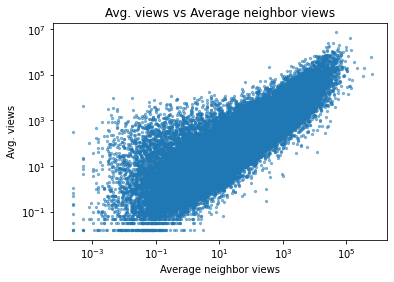

In [355]:
plt.scatter(avg_neighbour_view_lst, avg_view_list, s=5, marker='o', alpha=0.5)
plt.title("Figure 7b. Avg. views vs Avg. neighbor views")
plt.xlabel("Avg. neighbor views")
plt.ylabel("Avg. views")
plt.xscale('log')
plt.yscale('log')
# plt.show();
plt.savefig("7.jpg")

In [31]:
# plt.figure(figsize=(16, 8))
# mean_scatter(avg_neighbour_view_lst, avg_view_list)
# plt.title("Avg. views vs Average neighbor views")
# plt.ylabel("Average neighbor views")
# plt.xlabel("Avg. views")
# plt.xscale('log')
# plt.yscale('log')
# plt.show();

In [32]:
print(pearsonr(avg_view_list, avg_neighbour_ind_lst))
print(pearsonr(avg_view_list, avg_neighbour_view_lst))

(0.2223624729855948, 0.0)
(0.3741004716474447, 0.0)


60356
0.0008697865653986502 0.006322028317418505 0.04595155137619634
384 52 2792
49.12912366285077
0.6


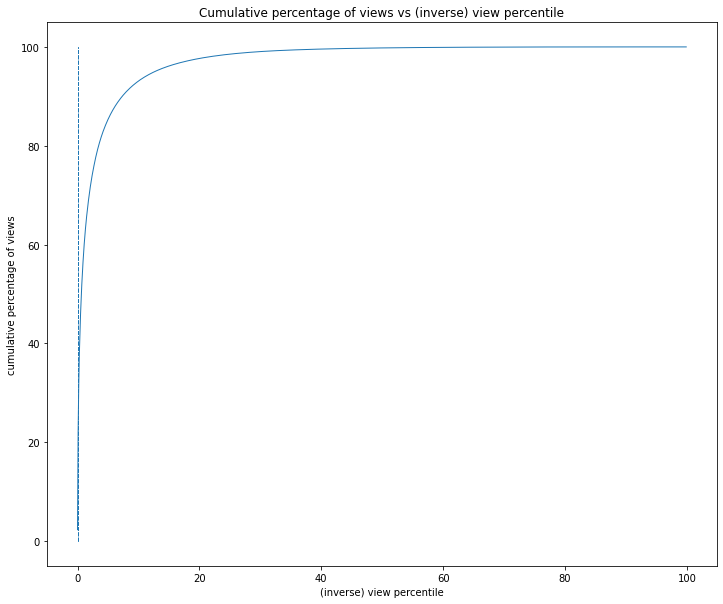

In [33]:
avg_view_sort_ind = np.argsort(avg_view_list)
sorted_avg_view_list = avg_view_list[avg_view_sort_ind]
sorted_ids = np.arange(num_videos)[avg_view_sort_ind]



total_views = np.sum(avg_view_list)


print(np.argmin(np.abs([(100*np.sum(sorted_avg_view_list[i:])/total_views-50) for i in range(num_videos)])))
N_50 = num_videos - np.argmin(np.abs([(100*np.sum(sorted_avg_view_list[i:])/total_views-50) for i in range(num_videos)]))
head_mid = math.floor(np.power(N_50, 2/3))
mid_tail = math.ceil(np.power(N_50, 4/3))
head_mid_pho = np.power(N_50, 2/3)/num_videos
mid_tail_pho = np.power(N_50, 4/3)/num_videos
print(head_mid_pho, N_50/num_videos, mid_tail_pho)
print(N_50, head_mid, mid_tail)
head_ids = sorted_ids[-head_mid:]
mid_ids = sorted_ids[mid_tail+1:head_mid]
tail_ids = sorted_ids[:mid_tail]

percentiles = np.arange(1000)/10
percentages = np.array([100*np.sum(avg_view_list[avg_view_list>=np.percentile(avg_view_list, 100-p)])/total_views for p in percentiles])
print(percentages[np.argmin(np.abs(percentages-50))])
print(percentiles[np.argmin(np.abs(percentages-50))])
# print(percentages[9])
plt.figure(figsize=(12, 10))
plt.vlines([head_mid_pho, N_50/num_videos, mid_tail_pho], 0, 100, linestyle='dashed')
plt.plot(percentiles, percentages)
plt.xlabel("(inverse) view percentile")
plt.ylabel("cumulative percentage of views")
plt.title("Cumulative percentage of views vs (inverse) view percentile")
# plt.xscale('symlog')
# plt.yscale('log')
plt.show()

In [34]:
print("gini: ", gini(avg_view_list))

gini:  0.9455318144031991


In [35]:
from_top_25_ind_list = []
from_top_50_ind_list = []
from_top_75_ind_list = []
from_top_100_ind_list = []
for i in tqdm(range(num_videos)):
    from_top_25_ind = 0
    from_top_50_ind = 0
    from_top_75_ind = 0
    from_top_100_ind = 0
    for t in range(1):
        if graph_lst[t].has_node(i):
            ind = 0
            for p in graph_lst[t].predecessors(i):
                percentile = percentileofscore(avg_view_list, embed_avg_view_dict[p])
                ind += 1 
                if percentile<=25:
                    from_top_100_ind+=1
                elif percentile<=50:
                    from_top_75_ind+=1
                elif percentile<=75:
                    from_top_50_ind+=1
                else:
                    from_top_25_ind+=1
            if ind != 0:
                from_top_25_ind = 100*from_top_25_ind/ind
                from_top_50_ind = 100*from_top_50_ind/ind
                from_top_75_ind = 100*from_top_75_ind/ind
                from_top_100_ind = 100*from_top_100_ind/ind
    from_top_25_ind_list.append(from_top_25_ind)
    from_top_50_ind_list.append(from_top_50_ind)
    from_top_75_ind_list.append(from_top_75_ind)
    from_top_100_ind_list.append(from_top_100_ind) # /T)
print(len(from_top_25_ind_list), from_top_25_ind_list[:5], from_top_50_ind_list[:5], from_top_75_ind_list[:5], from_top_100_ind_list[:5])

100%|██████████████████████████████████████████████████████████████████████████| 60740/60740 [00:29<00:00, 2044.52it/s]

60740 [0.0, 53.84615384615385, 0, 0, 0.0] [100.0, 46.15384615384615, 0, 0, 33.333333333333336] [0.0, 0.0, 0, 0, 50.0] [0.0, 0.0, 0, 0, 16.666666666666668]


In [36]:
from_top_25_ind_list_sorted = np.array(from_top_25_ind_list)[avg_view_sort_ind]
from_top_50_ind_list_sorted = np.array(from_top_50_ind_list)[avg_view_sort_ind]
from_top_75_ind_list_sorted = np.array(from_top_75_ind_list)[avg_view_sort_ind]
from_top_100_ind_list_sorted = np.array(from_top_100_ind_list)[avg_view_sort_ind]

In [41]:
# polyfit_25 = np.poly1d(np.polyfit(sorted_avg_view_list, from_top_25_ind_list_sorted, 20))(sorted_avg_view_list)
# polyfit_50 = np.poly1d(np.polyfit(sorted_avg_view_list, from_top_50_ind_list_sorted, 20))(sorted_avg_view_list)
# polyfit_75 = np.poly1d(np.polyfit(sorted_avg_view_list, from_top_75_ind_list_sorted, 20))(sorted_avg_view_list)

C:\Users\Yutian\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Yutian\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Yutian\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


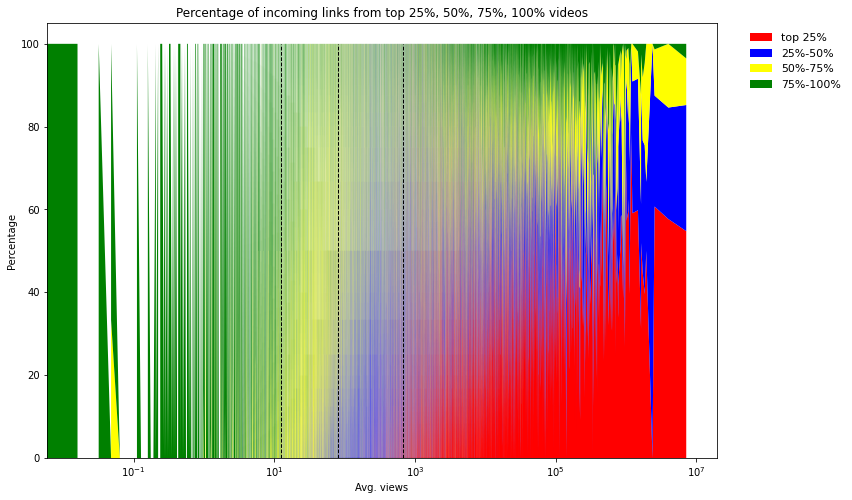

In [356]:


plt.figure(figsize=(12, 8))

plt.stackplot(sorted_avg_view_list, from_top_25_ind_list_sorted, from_top_50_ind_list_sorted, from_top_75_ind_list_sorted, from_top_100_ind_list_sorted,\
             labels=["top 25%", "25%-50%", "50%-75%", "75%-100%"] ,colors=["red", "blue", 'yellow','green'],)
plt.vlines([np.percentile(sorted_avg_view_list, 25), np.percentile(sorted_avg_view_list, 50), np.percentile(sorted_avg_view_list, 75)], 0, 100, \
           linestyle='dashed', colors=['yellow', "blue", "red"], label=['25%', '50%', '75%'])
plt.title("Figure 8. Percentage of incoming links from top 25%, 50%, 75%, 100% videos")
plt.xlabel("Avg. views")
plt.ylabel("Percentage")
plt.xscale('log')
# plt.yscale('log')
plt.legend(bbox_to_anchor=(1.2, 1), frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
# plt.show()
plt.savefig("8.jpg")

In [68]:
same_artist_percentage_list = np.zeros(num_videos)
same_genre_percentage_list = np.zeros(num_videos)
for i in range(T):
    for v in graph_lst[i].nodes():
        ind = 0
        same_artist_ind = 0
        same_genre_ind = 0
        for j in graph_lst[i].predecessors(v):
            ind += 1
            if embed_cid_dict[v] == embed_cid_dict[j]:
                same_artist_ind+=1
            if is_same_genre(embed_all_genre_dict[v], embed_all_genre_dict[j]):
                same_genre_ind+=1
        if ind != 0:
            same_artist_percentage_list[v]+=same_artist_ind/ind
            same_genre_percentage_list[v]+=same_genre_ind/ind                
same_artist_percentage_list = same_artist_percentage_list/T
same_genre_percentage_list = same_genre_percentage_list/T
print(pearsonr(avg_view_list, same_artist_percentage_list))
print(pearsonr(avg_view_list, same_genre_percentage_list))


(-0.07493965910316668, 2.270776931915187e-76)
(0.057324794291924594, 2.1740336689069096e-45)


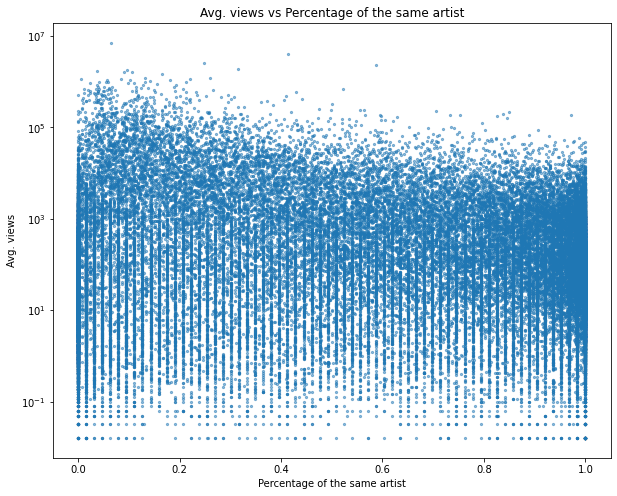

In [79]:
plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(same_artist_percentage_list, avg_view_list, s=5, marker='o', alpha=0.5)
plt.title("Avg. views vs Percentage of the same artist")
plt.xlabel("Percentage of the same artist")
plt.ylabel("Avg. views")
# plt.xscale('log')
plt.yscale('log')
plt.show();

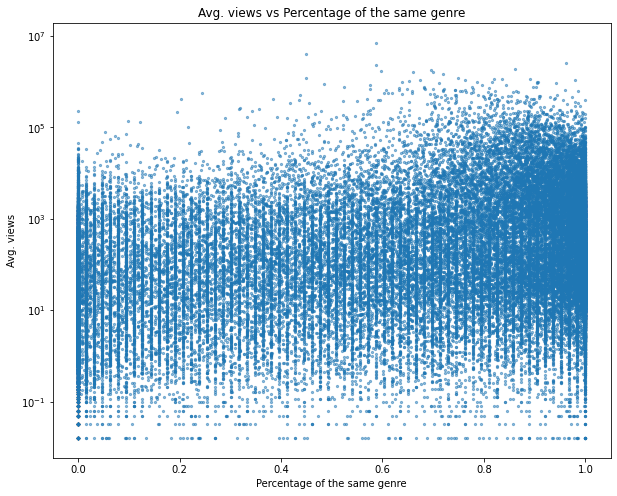

In [138]:
plt.figure(figsize=(10,8))
plt.scatter(same_genre_percentage_list, avg_view_list, s=5, marker='o', alpha=0.5)
plt.title("Avg. views vs Percentage of the same genre")
plt.xlabel("Percentage of the same genre")
plt.ylabel("Avg. views")
# plt.xscale('log')
plt.yscale('log')
plt.show();

In [81]:
ind_cc = np.stack((avg_ind_list, avg_cc_list, ), axis=-1)
print(ind_cc.shape)
ind_cc_X = sm.add_constant(ind_cc)
model = sm.OLS(avg_view_list,ind_cc_X)
results = model.fit()
results.summary()

(60740, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                 1.224e+04
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:52:24   Log-Likelihood:            -7.3591e+05
No. Observations:               60740   AIC:                         1.472e+06
Df Residuals:                   60737   BIC:                         1.472e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3047.4481    321.338     -9.484      0.000   -3677.272   -2417.624
x1          1348.2420      8.755    153.995      0.000    1331.082    1365.402
x2           593.2478   1720.811      0.345      0.730   -2779.547    3966.043
==============================================================================
Omnibus:                   208207.474   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     125245074090.381
Skew:                          63.673   Prob(JB):                         0.00
Kurtosis:                    7036.595   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
ind_cc = np.stack((avg_ind_list, avg_cc_list, avg_neighbour_ind_lst, same_artist_percentage_list, same_genre_percentage_list), axis=-1)
scaler = StandardScaler()
ind_cc_scaled = scaler.fit_transform(ind_cc)
ind_cc_X = sm.add_constant(ind_cc_scaled)
model = sm.OLS(avg_view_list,ind_cc_X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     4975.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:15:03   Log-Likelihood:            -7.3577e+05
No. Observations:               60740   AIC:                         1.472e+06
Df Residuals:                   60734   BIC:                         1.472e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5096.2114    178.995     28.471      0.000    4745.380    5447.042
x1          2.789e+04    205.257    135.855      0.000    2.75e+04    2.83e+04
x2           625.3200    194.378      3.217      0.001     244.339    1006.301
x3          1352.2884    218.374      6.193      0.000     924.274    1780.303
x4         -1830.9202    256.217     -7.146      0.000   -2333.106   -1328.734
x5         -1856.4346    261.998     -7.086      0.000   -2369.951   -1342.918
==============================================================================
Omnibus:                   208646.536   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     127739063002.795
Skew:                          64.070   Prob(JB):                         0.00
Kurtosis:                    7106.288   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
ind_cc = np.stack((avg_ind_list, avg_cc_list, avg_neighbour_ind_lst, same_artist_percentage_list, same_genre_percentage_list, ), axis=-1)
ind_cc_X = sm.add_constant(ind_cc)
model = sm.OLS(avg_view_list,ind_cc_X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     4975.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:52:08   Log-Likelihood:            -7.3577e+05
No. Observations:               60740   AIC:                         1.472e+06
Df Residuals:                   60734   BIC:                         1.472e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        421.3738    391.527      1.076      0.282    -346.021    1188.769
x1          1338.7932      9.855    135.855      0.000    1319.478    1358.108
x2          5900.8520   1834.250      3.217      0.001    2305.716    9495.987
x3           444.2461     71.739      6.193      0.000     303.637     584.855
x4         -4802.4061    672.043     -7.146      0.000   -6119.613   -3485.199
x5         -4750.5212    670.439     -7.086      0.000   -6064.585   -3436.458
==============================================================================
Omnibus:                   208646.536   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     127739063002.795
Skew:                          64.070   Prob(JB):                         0.00
Kurtosis:                    7106.288   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
embed_ratio_dict = {}
arnet_weights = dict()
with open(os.path.join('models', 'forecast_tracker_all.json'), 'r') as fin:
    for line in fin:
        result_json = json.loads(line.rstrip())
        tar_embed = result_json['embed']
        embed_ratio_dict[tar_embed] = result_json['net_ratio']
        src_embed = result_json['incoming_embeds']
        link_weights = result_json['link_weights']
        for i, s in enumerate(src_embed):
            arnet_weights[(s, tar_embed)] = link_weights[i]

In [92]:
persistent_graph = nx.DiGraph()
with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        edge_weight = arnet_weights[(src_embed, tar_embed)]*embed_avg_view_dict[src_embed]
        persistent_graph.add_edge(src_embed, tar_embed, weight=edge_weight)

In [95]:
print(persistent_graph.number_of_nodes())

31261


In [96]:
print(persistent_graph.number_of_edges())

52758


In [97]:


da_dg_list = []
da_sg_list = []
sa_dg_list = []
sa_sg_list = []
for j in embed_ratio_dict.keys():
    da_dg = 0
    da_sg = 0
    sa_dg = 0
    sa_sg = 0        

    avg_ind = persistent_graph.in_degree(j)
    if avg_ind == 0:
        da_dg_list.append(0)
        da_sg_list.append(0)
        sa_dg_list.append(0)
        sa_sg_list.append(0)
    else:            
        for src in persistent_graph.predecessors(j):
            if (embed_cid_dict[src] == embed_cid_dict[j]) and is_same_genre(embed_all_genre_dict[src], embed_all_genre_dict[j]):
                sa_sg += 1
            elif (embed_cid_dict[src] != embed_cid_dict[j]) and is_same_genre(embed_all_genre_dict[src], embed_all_genre_dict[j]):
                da_sg += 1
            elif (embed_cid_dict[src] == embed_cid_dict[j]) and not is_same_genre(embed_all_genre_dict[src], embed_all_genre_dict[j]):
                sa_dg += 1
            else:
                da_dg += 1

        da_dg_list.append(da_dg/avg_ind)
        da_sg_list.append(da_sg/avg_ind)
        sa_dg_list.append(sa_dg/avg_ind)
        sa_sg_list.append(sa_sg/avg_ind)

avg_da_dg = np.mean(da_dg_list)
avg_da_sg = np.mean(da_sg_list)
avg_sa_dg = np.mean(sa_dg_list)
avg_sa_sg = np.mean(sa_sg_list)
total_avg = avg_da_dg+ avg_da_sg+ avg_sa_dg+ avg_sa_sg
print(avg_da_dg/total_avg, avg_da_sg/total_avg, avg_sa_dg/total_avg, avg_sa_sg/total_avg)

0.026693829655827103 0.17671801297023818 0.0794149530788755 0.7171732042950593


In [102]:
def print_stats(lst, lst2):
    print("mean: ", np.mean(lst), "std: ", np.std(lst), "min, ", np.min(lst), "max: ", np.max(lst), "corr: ", pearsonr(lst2, lst))

In [107]:
persistent_ids=np.array(list(embed_ratio_dict.keys())) # only incoming nodes
ratio_list = np.array([embed_ratio_dict[i] for i in persistent_ids])
persistent_avg_cc_list = avg_cc_list[persistent_ids]
persistent_avg_ind_list = avg_ind_list[persistent_ids]
persistent_avg_neighbour_ind_lst = avg_neighbour_ind_lst[persistent_ids]
persistent_avg_view_list = avg_view_list[persistent_ids]
persistent_same_artist_percentage_list = same_artist_percentage_list[persistent_ids]
persistent_same_genre_percentage_list = same_genre_percentage_list[persistent_ids]
for lst in [avg_cc_list, avg_ind_list, avg_neighbour_ind_lst, same_artist_percentage_list, same_genre_percentage_list]:     
    print_stats(lst, avg_view_list)
    
for lst in [persistent_avg_cc_list, persistent_avg_ind_list, persistent_avg_neighbour_ind_lst, persistent_same_artist_percentage_list, persistent_same_genre_percentage_list]:
    print_stats(lst, persistent_avg_view_list)

mean:  0.14656105445036346 std:  0.10597113300461115 min,  0.0 max:  0.9587301587301587 corr:  (-0.09486011659291047, 2.06011975451955e-121)
mean:  5.97571668992479 std:  20.828589212764456 min,  0.0 max:  870.6190476190476 corr:  (0.535981654161106, 0.0)
mean:  2.254197312138783 std:  3.044007014387854 min,  0.0 max:  61.64179894179895 corr:  (0.2223624729855948, 0.0)
mean:  0.544755469444726 std:  0.3812506002694324 min,  0.0 max:  1.0 corr:  (-0.07493965910316668, 2.270776931915187e-76)
mean:  0.5421568508530763 std:  0.3907854640087513 min,  0.0 max:  1.0 corr:  (0.057324794291924594, 2.1740336689069096e-45)
mean:  0.12255549972341791 std:  0.09442165358863411 min,  0.0 max:  0.8347333883048168 corr:  (-0.166286949389215, 1.39179787034529e-85)
mean:  19.558183691662904 std:  40.27852575741781 min,  0.8253968253968254 max:  870.6190476190476 corr:  (0.5503170179231526, 0.0)
mean:  4.792728850804488 std:  4.141176318195425 min,  0.0 max:  61.64179894179895 corr:  (0.23373522052276707

mean:  0.3138309326602185 std:  0.23277807105180778 min,  0.0 max:  1.0 corr:  (0.005229123881839083, 0.5403889339086926)
None


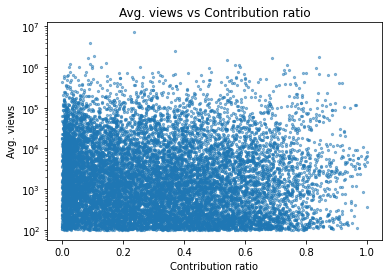

In [115]:
print(print_stats(ratio_list, persistent_avg_view_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(ratio_list, persistent_avg_view_list, s=5, marker='o', alpha=0.5)
plt.title("Avg. views vs Contribution ratio")
plt.xlabel("Contribution ratio")
plt.ylabel("Avg. views")
# plt.xscale('log')
plt.yscale('log')
plt.show();

In [119]:
persistent_avg_view_list_no_network = (1-ratio_list)*persistent_avg_view_list

head_mid_pho, N_50/num_videos, mid_tail_pho:  0.0008697865653986502 0.006322028317418505 0.04595155137619634
N_50, head_mid, mid_tail:  384 52 2792
gini:  0.9455318144031991
head_mid_pho, N_50/num_videos, mid_tail_pho:  0.021528491389648022 0.7784985182746131 28.151528687569414
N_50, head_mid, mid_tail:  47286 1307 1709924
gini:  0.8785658668002166
head_mid_pho, N_50/num_videos, mid_tail_pho:  0.021529098428789462 0.778531445505433 28.15311628796611
N_50, head_mid, mid_tail:  47288 1307 1710021
gini:  0.8805716504355856


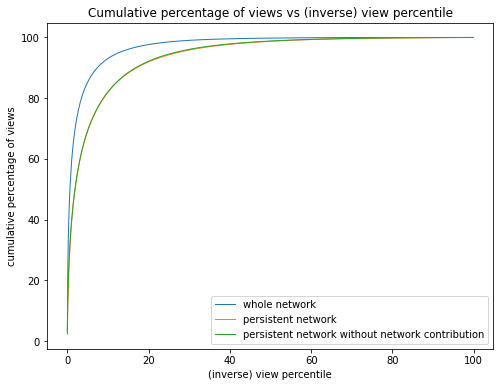

In [357]:
def plot_cumulative(avg_view_list):
    avg_view_sort_ind = np.argsort(avg_view_list)
    sorted_avg_view_list = avg_view_list[avg_view_sort_ind]
    sorted_ids = np.arange(num_videos)[avg_view_sort_ind]

    total_views = np.sum(avg_view_list)

    N_50 = num_videos - np.argmin(np.abs([(100*np.sum(sorted_avg_view_list[i:])/total_views-50) for i in range(num_videos)]))
    head_mid = math.floor(np.power(N_50, 2/3))
    mid_tail = math.ceil(np.power(N_50, 4/3))
    head_mid_pho = np.power(N_50, 2/3)/num_videos
    mid_tail_pho = np.power(N_50, 4/3)/num_videos
    print("head_mid_pho, N_50/num_videos, mid_tail_pho: ", head_mid_pho, N_50/num_videos, mid_tail_pho)
    print("N_50, head_mid, mid_tail: ", N_50, head_mid, mid_tail)
    head_ids = sorted_ids[-head_mid:]
    mid_ids = sorted_ids[mid_tail+1:head_mid]
    tail_ids = sorted_ids[:mid_tail]

    percentiles = np.arange(1000)/10
    percentages = np.array([100*np.sum(avg_view_list[avg_view_list>=np.percentile(avg_view_list, 100-p)])/total_views for p in percentiles])
    print("gini: ", gini(avg_view_list))
    
#     plt.vlines([head_mid_pho, N_50/num_videos, mid_tail_pho], 0, 100, linestyle='dashed')
    plt.plot(percentiles, percentages)
    
plt.figure(figsize=(8, 6))
plot_cumulative(avg_view_list)
plot_cumulative(persistent_avg_view_list)
plot_cumulative(persistent_avg_view_list_no_network)
plt.xlabel("(inverse) view percentile")
plt.ylabel("cumulative percentage of views")
plt.title("Figure 2. Cumulative percentage of views vs (inverse) view percentile")
plt.legend(["whole network", "persistent network", "persistent network without network contribution"])
# plt.xscale('symlog')
# plt.yscale('log')
# plt.show()
plt.savefig("5.jpg")

(0.09274095906153562, 1.4125300665104412e-27)


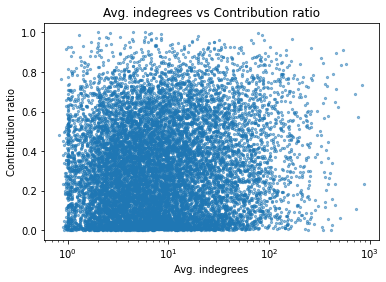

In [247]:
print(pearsonr(ratio_list, persistent_avg_ind_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(persistent_avg_ind_list, ratio_list, s=5, marker='o', alpha=0.5)
plt.title("Avg. indegrees vs Contribution ratio")
plt.xlabel("Avg. indegrees")
plt.ylabel("Contribution ratio")
plt.xscale('log')
# plt.yscale('log')
plt.show();

(0.2592440704919022, 2.118545804085819e-209)


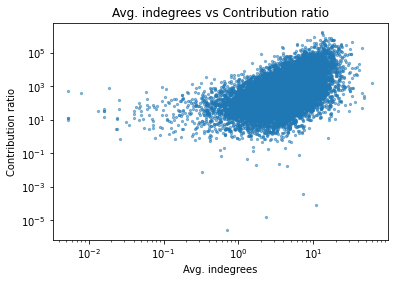

In [244]:
print(pearsonr(ratio_list*persistent_avg_view_list, persistent_avg_neighbour_ind_lst))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(persistent_avg_neighbour_ind_lst, ratio_list*persistent_avg_view_list, s=5, marker='o', alpha=0.5)
plt.title("Avg. indegrees vs Contribution ratio")
plt.xlabel("Avg. indegrees")
plt.ylabel("Contribution ratio")
plt.xscale('log')
plt.yscale('log')
plt.show();

(0.17385853156120337, 1.6969652802024417e-93)


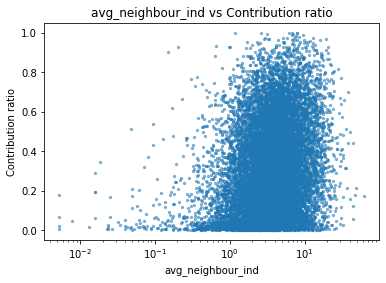

In [243]:
print(pearsonr(ratio_list, persistent_avg_neighbour_ind_lst))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(persistent_avg_neighbour_ind_lst, ratio_list, s=5, marker='o', alpha=0.5)
plt.title("avg_neighbour_ind vs Contribution ratio")
plt.xlabel("avg_neighbour_ind")
plt.ylabel("Contribution ratio")
plt.xscale('log')
# plt.yscale('log')
plt.show();

(0.1764603488335204, 2.656153712996902e-96)


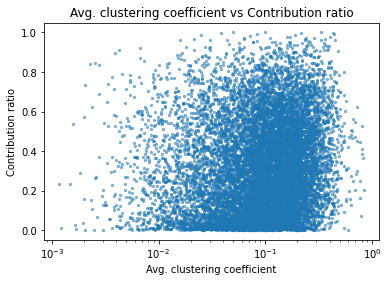

In [251]:
print(pearsonr(ratio_list, persistent_avg_cc_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(persistent_avg_cc_list, ratio_list, s=5, marker='o', alpha=0.5)
plt.title("Avg. clustering coefficient vs Contribution ratio")
plt.xlabel("Avg. clustering coefficient")
plt.ylabel("Contribution ratio")
plt.xscale('log')
# plt.yscale('log')
plt.show();

(-0.21719656658010894, 4.508952843914576e-146)


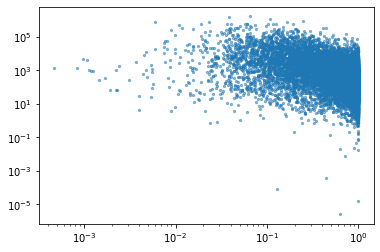

In [262]:
print(pearsonr(ratio_list*persistent_avg_view_list, persistent_same_artist_percentage_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(persistent_same_artist_percentage_list, ratio_list*persistent_avg_view_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
plt.xscale('log')
plt.yscale('log')
plt.show();

(-0.030641599190234986, 0.00033280119881868534)


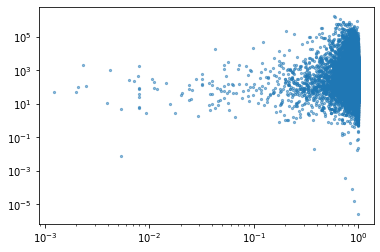

In [263]:
print(pearsonr(ratio_list*persistent_avg_view_list, persistent_same_genre_percentage_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(persistent_same_genre_percentage_list, ratio_list*persistent_avg_view_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
plt.xscale('log')
plt.yscale('log')
plt.show();

In [180]:
from_top_25_view_list = []
from_top_50_view_list = []
from_top_75_view_list = []
from_top_100_view_list = []
contributed_views = []
for i in persistent_ids:
    from_top_25_view = 0
    from_top_50_view = 0
    from_top_75_view = 0
    from_top_100_view = 0
    view = 0
    for p in persistent_graph.predecessors(i):
        avg_view = embed_avg_view_dict[p]
        percentile = percentileofscore(avg_view_list, embed_avg_view_dict[p])
        view += avg_view*arnet_weights[(p, i)]
        if percentile<=25:
            from_top_100_view+=avg_view*arnet_weights[(p, i)]
        elif percentile<=50:
            from_top_75_view+=avg_view*arnet_weights[(p, i)]
        elif percentile<=75:
            from_top_50_view+=avg_view*arnet_weights[(p, i)]
        else:
            from_top_25_view+=avg_view*arnet_weights[(p, i)]
    if view != 0:
        from_top_25_view = 100*from_top_25_view/view
        from_top_50_view = 100*from_top_50_view/view
        from_top_75_view = 100*from_top_75_view/view
        from_top_100_view = 100*from_top_100_view/view
    from_top_25_view_list.append(from_top_25_view)
    from_top_50_view_list.append(from_top_50_view)
    from_top_75_view_list.append(from_top_75_view)
    from_top_100_view_list.append(from_top_100_view) # /T)
    contributed_views.append(view)


In [154]:
ratio_list_sort_ind = np.argsort(ratio_list)
ratio_list_sorted = np.array(ratio_list)[ratio_list_sort_ind]
from_top_25_view_list_sorted = np.array(from_top_25_view_list)[ratio_list_sort_ind]
from_top_50_view_list_sorted = np.array(from_top_50_view_list)[ratio_list_sort_ind]
from_top_75_view_list_sorted = np.array(from_top_75_view_list)[ratio_list_sort_ind]
from_top_100_view_list_sorted = np.array(from_top_100_view_list)[ratio_list_sort_ind]

In [164]:
persistent_avg_view_sort_ind = np.argsort(persistent_avg_view_list)
sorted_persistent_avg_view_list = persistent_avg_view_list[persistent_avg_view_sort_ind]
from_top_25_view_list_sorted = np.array(from_top_25_view_list)[persistent_avg_view_sort_ind]
from_top_50_view_list_sorted = np.array(from_top_50_view_list)[persistent_avg_view_sort_ind]
from_top_75_view_list_sorted = np.array(from_top_75_view_list)[persistent_avg_view_sort_ind]
from_top_100_view_list_sorted = np.array(from_top_100_view_list)[persistent_avg_view_sort_ind]
# sorted_ids = np.arange(num_videos)[avg_view_sort_ind]

In [166]:
len(sorted_persistent_avg_view_list[sorted_persistent_avg_view_list>np.percentile(sorted_avg_view_list, 75)])/len(sorted_persistent_avg_view_list)

0.6218818380743982

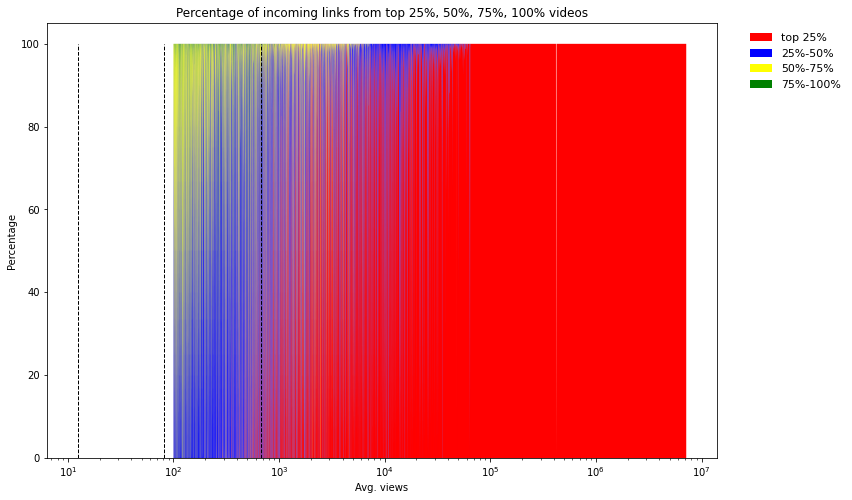

In [165]:
plt.figure(figsize=(12, 8))

plt.stackplot(sorted_persistent_avg_view_list, from_top_25_view_list_sorted, from_top_50_view_list_sorted, from_top_75_view_list_sorted, from_top_100_view_list_sorted,\
             labels=["top 25%", "25%-50%", "50%-75%", "75%-100%"] ,colors=["red", "blue", 'yellow','green'],)
plt.vlines([np.percentile(sorted_avg_view_list, 25), np.percentile(sorted_avg_view_list, 50), np.percentile(sorted_avg_view_list, 75)], 0, 100, linestyle='dashed', color='black')
plt.title("Percentage of incoming links from top 25%, 50%, 75%, 100% videos")
plt.xlabel("Avg. views")
plt.ylabel("Percentage")
plt.xscale('log')
# plt.yscale('log')
plt.legend(bbox_to_anchor=(1.2, 1), frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show()

In [270]:
# plt.figure(figsize=(20, 10))
sa_sg_src_list = []
sa_sg_tar_list = []
sa_dg_src_list = []
sa_dg_tar_list = []
da_sg_src_list = []
da_sg_tar_list = []
da_dg_src_list = []
da_dg_tar_list = []
sa_sg_weight_list = []
sa_dg_weight_list = []
da_sg_weight_list = []
da_dg_weight_list = []
# color_list = []
# label_list = []
with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        edge_weight = arnet_weights[(src_embed, tar_embed)]
        tar_ind = np.nonzero(persistent_ids==tar_embed)[0][0]
        if edge_weight*embed_avg_view_dict[src_embed] != 0:
            weight = edge_weight*embed_avg_view_dict[src_embed]/contributed_views[tar_ind]
        else:
            weight = 0
        weight = weight*20
#         weight_list.append(weight*500000) # better squash function
        
        if (embed_cid_dict[src_embed] == embed_cid_dict[tar_embed]) and is_same_genre(embed_all_genre_dict[src_embed], embed_all_genre_dict[tar_embed]):
            
            sa_sg_src_list.append(embed_avg_view_dict[src_embed])
            sa_sg_tar_list.append(embed_avg_view_dict[tar_embed])
            sa_sg_weight_list.append(weight)
#             color_list.append(ColorPalette.CC4[0])
#             label_list.append("same artist same genre")
        elif (embed_cid_dict[src_embed] != embed_cid_dict[tar_embed]) and is_same_genre(embed_all_genre_dict[src_embed], embed_all_genre_dict[tar_embed]):
            da_sg_src_list.append(embed_avg_view_dict[src_embed])
            da_sg_tar_list.append(embed_avg_view_dict[tar_embed])
            da_sg_weight_list.append(weight)
#             color_list.append(ColorPalette.CC4[1])
#             label_list.append("different artist")
#             label_list.append("different artist same genre")
        elif (embed_cid_dict[src_embed] == embed_cid_dict[tar_embed]) and not is_same_genre(embed_all_genre_dict[src_embed], embed_all_genre_dict[tar_embed]):
            sa_dg_src_list.append(embed_avg_view_dict[src_embed])
            sa_dg_tar_list.append(embed_avg_view_dict[tar_embed])
            sa_dg_weight_list.append(weight)
#             color_list.append(ColorPalette.CC4[0])
#             label_list.append("same artist")
#             label_list.append("same artist different genre")
        else:
            da_dg_src_list.append(embed_avg_view_dict[src_embed])
            da_dg_tar_list.append(embed_avg_view_dict[tar_embed])
            da_dg_weight_list.append(weight)
#             color_list.append(ColorPalette.CC4[1])
#             label_list.append("different artist")
#             label_list.append("different artist different genre")
print(sa_sg_weight_list[:5])

[19.880906665944035, 0.11909333405596594, 0.22893900960446215, 3.606770860284424, 0.8826473857254719]


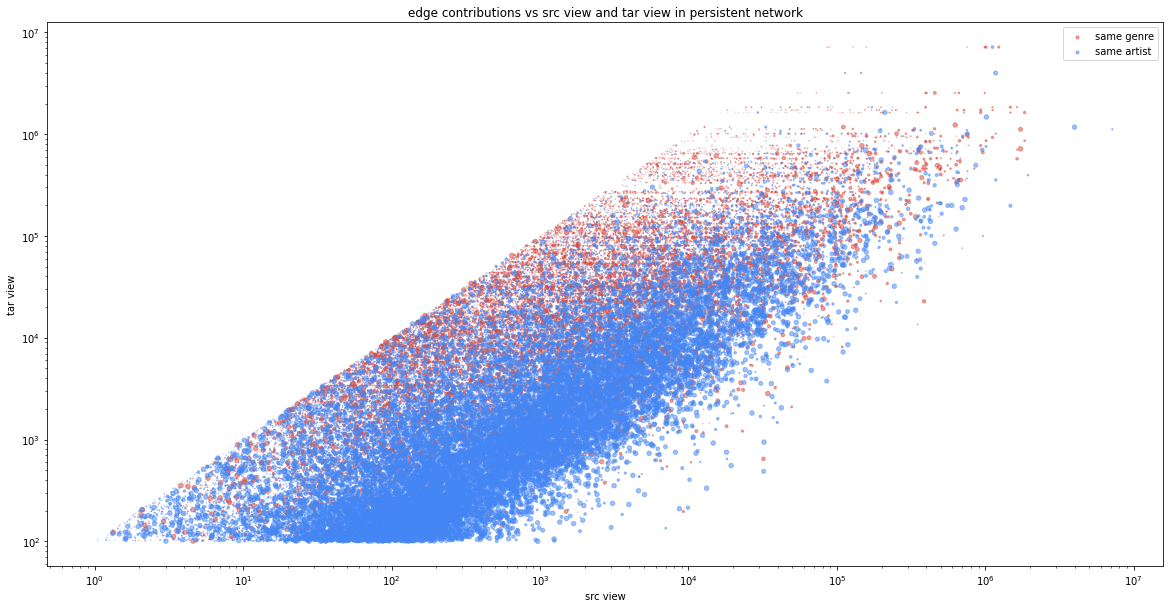

In [343]:
plt.figure(figsize=(20, 10))
plt.scatter(da_sg_src_list, da_sg_tar_list, s=da_sg_weight_list, c=ColorPalette.CC4[3], label='same genre', marker='o', alpha=0.5)
plt.scatter(da_dg_src_list, da_dg_tar_list, s=da_dg_weight_list, c=ColorPalette.CC4[3], marker='o', alpha=0.5)
plt.scatter(sa_sg_src_list, sa_sg_tar_list, s=sa_sg_weight_list, c=ColorPalette.CC4[0],marker='o', alpha=0.5)
plt.scatter(sa_dg_src_list, sa_dg_tar_list, s=sa_dg_weight_list, c=ColorPalette.CC4[0], label='same artist',marker='o', alpha=0.5)

plt.title("Figure 9. Edge contributions vs src view and tar view in persistent network")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("src view")
plt.ylabel("tar view")
plt.savefig("9.jpg")

Text(0, 0.5, 'tar view')

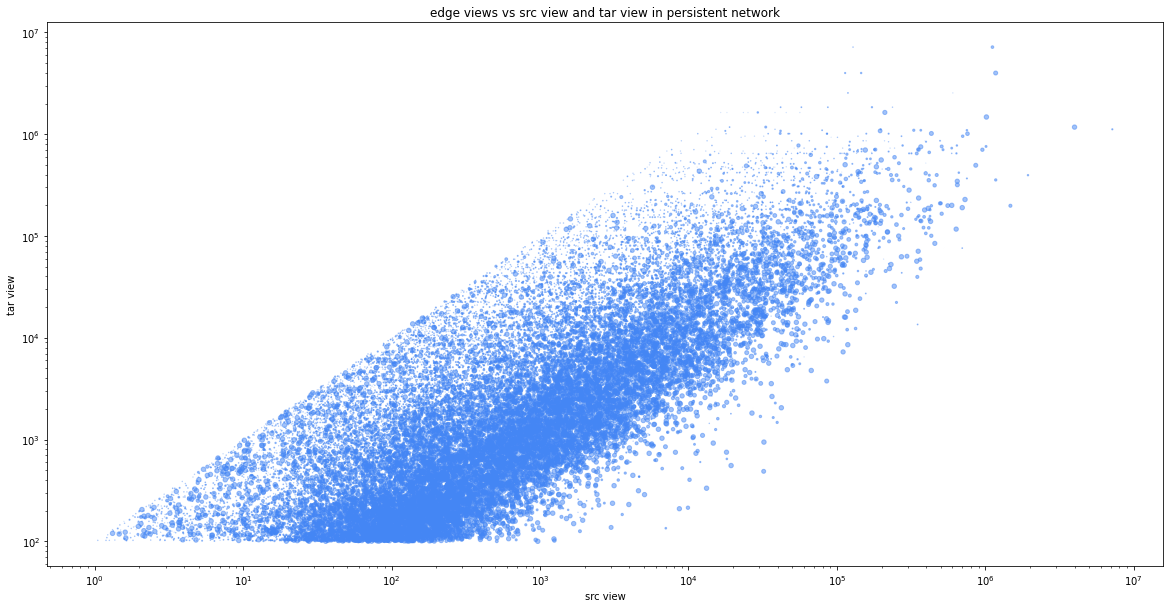

In [274]:
plt.figure(figsize=(20, 10))
plt.scatter(sa_sg_src_list, sa_sg_tar_list, s=sa_sg_weight_list, c=ColorPalette.CC4[0], marker='o', alpha=0.5, label=label_list)
plt.title("edge views vs src view and tar view in persistent network")
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.xlabel("src view")
plt.ylabel("tar view")

Text(0, 0.5, 'tar view')

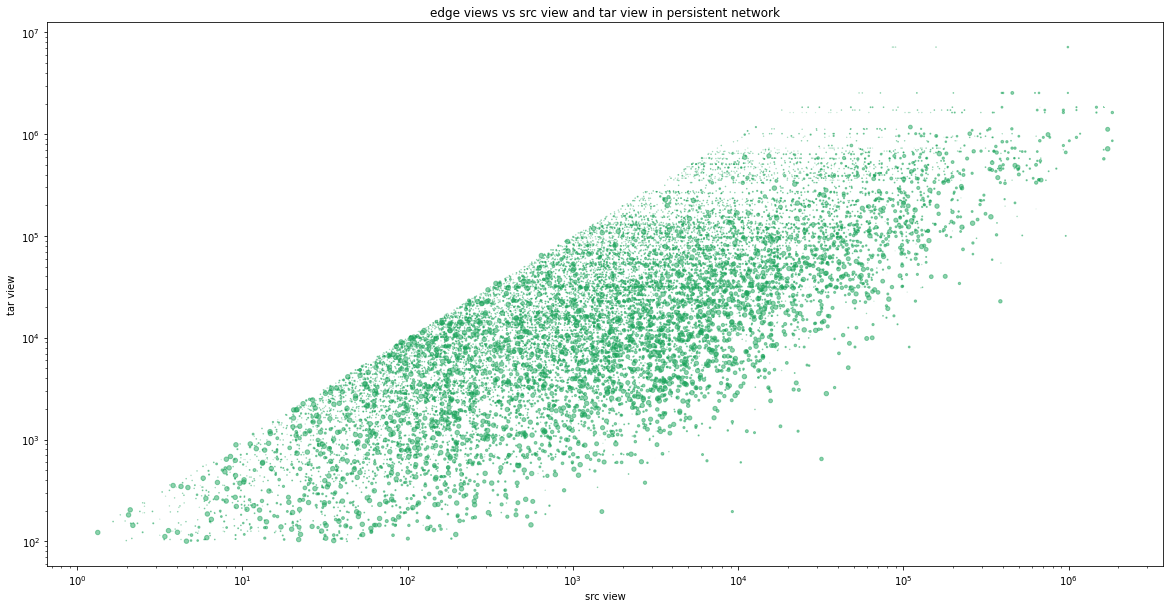

In [273]:
plt.figure(figsize=(20, 10))
plt.scatter(da_sg_src_list, da_sg_tar_list, s=da_sg_weight_list, c=ColorPalette.CC4[1], marker='o', alpha=0.5, label=label_list)
plt.title("edge views vs src view and tar view in persistent network")
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.xlabel("src view")
plt.ylabel("tar view")

Text(0, 0.5, 'tar view')

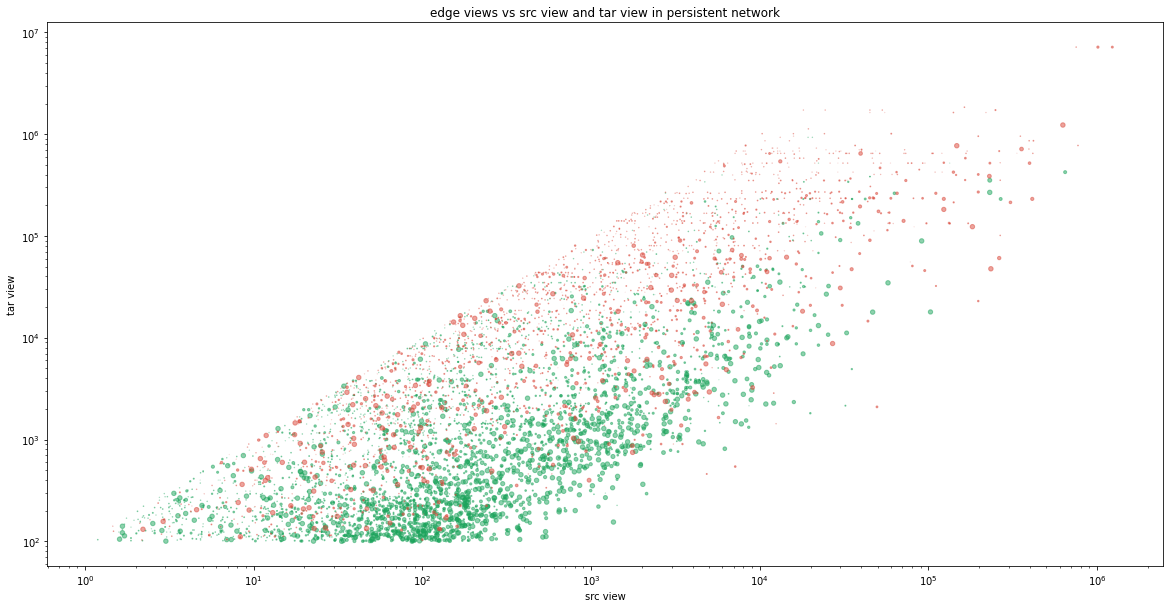

In [278]:
plt.figure(figsize=(20, 10))
plt.scatter(sa_dg_src_list, sa_dg_tar_list, s=sa_dg_weight_list, c=ColorPalette.CC4[1], marker='o', alpha=0.5, label=label_list)
plt.scatter(da_dg_src_list, da_dg_tar_list, s=da_dg_weight_list, c=ColorPalette.CC4[3], marker='o', alpha=0.5, label=label_list)

plt.title("edge views vs src view and tar view in persistent network")
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.xlabel("src view")
plt.ylabel("tar view")

Text(0, 0.5, 'tar view')

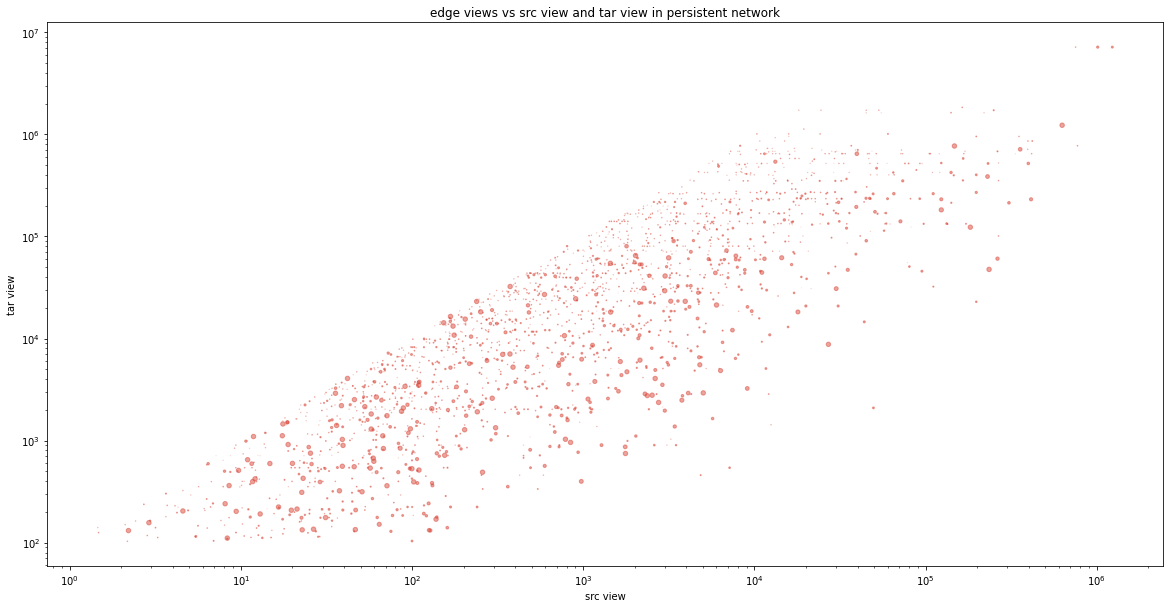

In [276]:
plt.figure(figsize=(20, 10))
plt.scatter(da_dg_src_list, da_dg_tar_list, s=da_dg_weight_list, c=ColorPalette.CC4[3], marker='o', alpha=0.5, label=label_list)
plt.title("edge views vs src view and tar view in persistent network")
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.xlabel("src view")
plt.ylabel("tar view")

In [282]:
percentile_change_list = [percentileofscore(persistent_avg_view_list, persistent_avg_view_list[i])\
                          -percentileofscore(persistent_avg_view_list_no_network, persistent_avg_view_list_no_network[i]) for i in range(len(persistent_ids))]

(0.8616649696408457, 0.0)


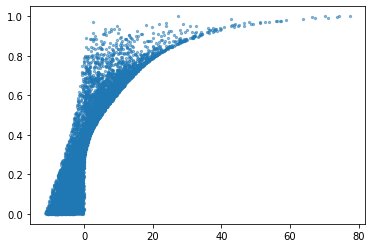

In [286]:
print(pearsonr(ratio_list, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, ratio_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
# plt.yscale('log')
plt.show();

(0.011365014832353651, 0.18330488752437948)


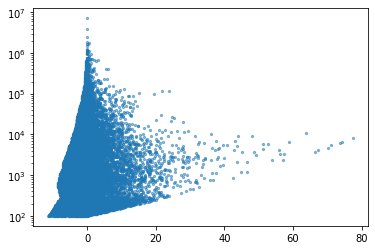

In [289]:
print(pearsonr(persistent_avg_view_list, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, persistent_avg_view_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
plt.yscale('log')
plt.show();

(0.0035415943051479845, 0.6783997964947858)


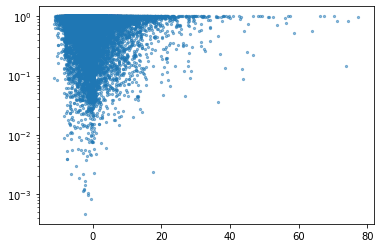

In [299]:
print(pearsonr(persistent_same_artist_percentage_list, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, persistent_same_artist_percentage_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
plt.yscale('log')
plt.show();

(0.044691353066129445, 1.6495274989989376e-07)


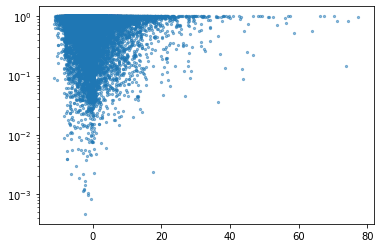

In [335]:
print(pearsonr(persistent_same_genre_percentage_list, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, persistent_same_artist_percentage_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
plt.yscale('log')
plt.show();

(0.07382025747106154, 4.9458296837146374e-18)


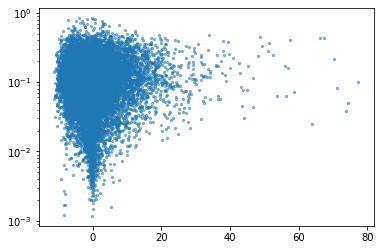

In [337]:
print(pearsonr(persistent_avg_cc_list, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, persistent_avg_cc_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
plt.yscale('log')
plt.show();

(0.09079897460445854, 1.6944223648456877e-26)


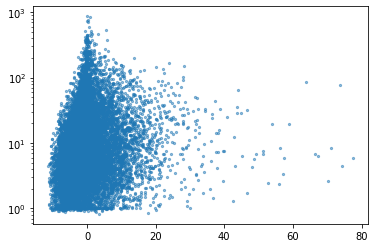

In [338]:
print(pearsonr(persistent_avg_ind_list, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, persistent_avg_ind_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
plt.yscale('log')
plt.show();

(0.17880791483218023, 7.162626838380992e-99)


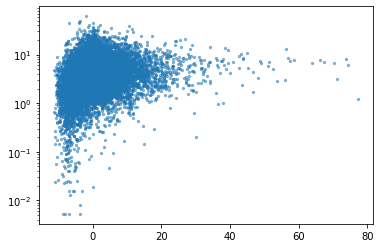

In [340]:
print(pearsonr(persistent_avg_neighbour_ind_lst, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, persistent_avg_neighbour_ind_lst, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
plt.yscale('log')
plt.show();

In [ ]:
print(pearsonr(persistent_avg_ind_list, percentile_change_list))
# plt.figure(figsize=(10,8))
# mean_scatter(same_artist_percentage_list, avg_view_list) #s=5, marker='o', alpha=0.5)
plt.scatter(percentile_change_list, persistent_avg_cc_list, s=5, marker='o', alpha=0.5)
# plt.title("Avg. clustering coefficient vs Contribution ratio")
# plt.xlabel("Avg. clustering coefficient")
# plt.ylabel("Contribution ratio")
# plt.xscale('log')
plt.yscale('log')
plt.show();

In [301]:
for i in persistent_ids[np.array(percentile_change_list)>60]:
    print("title: ", embed_title_dict[i])
    print("genre: ", embed_genre_dict[i])
    print("views: ", embed_avg_view_dict[i])

title:  Chris Stapleton - When The Stars Come Out (Audio)
genre:  ['Country_music']
views:  8234.63492063492
title:  The Style Council - Shout To The Top
genre:  ['Pop_music']
views:  6267.190476190476
title:  R. Kelly - Trapped in the Closet Chapter 12
genre:  ['Pop_music']
views:  4163.412698412699
title:  Ellie Goulding - Guns And Horses
genre:  ['Electronic_music', 'Independent_music', 'Pop_music']
views:  6364.31746031746
title:  Breaking Benjamin - Down (Audio)
genre:  ['Rock_music']
views:  4778.841269841269
title:  Lauren Daigle - Here's My Heart (Audio)
genre:  ['Pop_music']
views:  5672.761904761905
title:  R. Kelly - Trapped in the Closet Chapter 14
genre:  []
views:  3644.1746031746034
title:  Kenny Chesney - Save It for a Rainy Day
genre:  ['Country_music']
views:  10975.031746031746


In [ ]:
['Mindless Behavior - Hello', 'R. Kelly - Trapped in the Closet Chapter 12', 
"Kacey Musgraves - Merry Go 'Round", 

In [15]:
vid_by_genres = defaultdict(list)

In [16]:
for i in range(num_videos):
    if len(embed_genre_dict[i]) == 0:
        vid_by_genres["NoInfo"].append(i)
    else:
        for j in embed_genre_dict[i]:
            vid_by_genres[j].append(i)
print([(k, len(v)) for k, v in vid_by_genres.items()])

[('Hip_hop_music', 10850), ('Pop_music', 22587), ('Soul_music', 4341), ('Rock_music', 14662), ('Independent_music', 7250), ('Country_music', 4398), ('Electronic_music', 4461), ('NoInfo', 7582)]


In [27]:
topics = ['Pop_music', 'Rock_music', 'Hip_hop_music', 'Independent_music',
                    'Country_music', 'Electronic_music', 'Soul_music', 'Others']
avg_view_topic = []
avg_cc_topic = []
avg_ind_topic = []
for i in topics:
    avg_view_topic.append(np.mean(avg_view_list[vid_by_genres[i]]))
    avg_cc_topic.append(np.mean(avg_cc_list[vid_by_genres[i]]))
    avg_ind_topic.append(np.mean(avg_ind_list[vid_by_genres[i]]))


In [59]:
all_topics = []
for i in embed_all_genre_dict.values():
    for j in i:
        if j not in all_topics:
            all_topics.append(j)
print(all_topics)
for i in ['Television_program', 'Military', 'Entertainment', 'Performing_arts', 'Film','Music_of_Asia', 'Music_of_Latin_America']:
    all_topics.remove(i)
print(all_topics)

['Pop_music', 'Electronic_music', 'Rhythm_and_blues', 'Country_music', 'Soul_music', 'Reggae', 'Independent_music', 'Rock_music', 'Hip_hop_music', 'Music_of_Latin_America', 'Military', 'Jazz', 'Television_program', 'Christian_music', 'Music_of_Asia', 'Classical_music', 'Entertainment', 'Performing_arts', 'Film']
['Pop_music', 'Electronic_music', 'Rhythm_and_blues', 'Country_music', 'Soul_music', 'Reggae', 'Independent_music', 'Rock_music', 'Hip_hop_music', 'Jazz', 'Christian_music', 'Classical_music']


In [32]:
vid_by_all_genres = defaultdict(list)
for i in range(num_videos):
    if len(embed_all_genre_dict[i]) == 0:
        vid_by_all_genres["NoInfo"].append(i)
    else:
        for j in embed_all_genre_dict[i]:
            vid_by_all_genres[j].append(i)
print([(k, len(v)) for k, v in vid_by_all_genres.items()])

[('Hip_hop_music', 10850), ('Pop_music', 22587), ('Rhythm_and_blues', 3926), ('Soul_music', 4341), ('Rock_music', 14662), ('Independent_music', 7250), ('Country_music', 4398), ('Electronic_music', 4461), ('NoInfo', 4357), ('Christian_music', 2866), ('Reggae', 362), ('Jazz', 878), ('Music_of_Latin_America', 366), ('Classical_music', 272), ('Television_program', 152), ('Military', 31), ('Entertainment', 4), ('Performing_arts', 2), ('Music_of_Asia', 21), ('Film', 1)]


In [60]:
avg_view_topic = []
avg_cc_topic = []
avg_ind_topic = []
for i in all_topics:
    avg_view_topic.append(np.mean(avg_view_list[vid_by_all_genres[i]]))
    avg_cc_topic.append(np.mean(avg_cc_list[vid_by_all_genres[i]]))
    avg_ind_topic.append(np.mean(avg_ind_list[vid_by_all_genres[i]]))
avg_view_topic = np.array(avg_view_topic)
avg_ind_topic = np.array(avg_ind_topic)
avg_cc_topic = np.array(avg_cc_topic)


Text(0.5, 0, 'Average views')

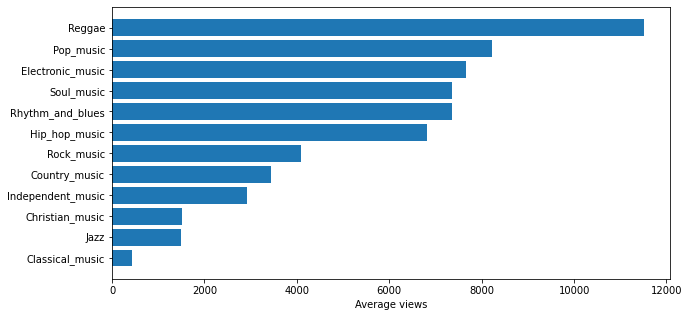

In [83]:
plt.figure(figsize=(10, 5))
all_topics = np.array(all_topics)
ind_sort = np.argsort(avg_view_topic)
avg_view_topic_sorted = avg_view_topic[ind_sort]
all_topics_sorted = all_topics[ind_sort]
plt.barh(all_topics_sorted, avg_view_topic_sorted)
plt.xlabel("Average views")